Importing Libraries/Packages

In [ ]:
#Reproducibility
import os
import numpy as np
import random as rn
import tensorflow as tf

# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

#
import pandas as pd
from sklearn.utils import shuffle

#Visualization: Graphs
import seaborn as sns
import matplotlib.pyplot as plt

#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Scaling
from sklearn.preprocessing import RobustScaler

#Training Testing
from sklearn.model_selection import train_test_split

#Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, SimpleRNN, LSTM
from keras.callbacks import History
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint

#metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

#loading
from keras.models import load_model

Mounted at /content/drive


Setting Seeds for Reproducibility

In [ ]:
os.environ['PYTHONHASHSEED']='0'
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

In [ ]:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Loading CSV Files

In [ ]:
table_1=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_1.csv")
table_2=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_2.csv")
table_3=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_3.csv")
table_4=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_4.csv")
table_5=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_5.csv")
table_6=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_6.csv")

Merge all Files into a DataFrame

In [ ]:
dataset = pd.concat([table_1,table_2,table_3,table_4,table_5,table_6])
dataset.reset_index(drop=True, inplace=True)

In [ ]:
dataset.shape

(6228310, 17)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6228310 entries, 0 to 6228309
Data columns (total 17 columns):
 #   Column         Dtype  
---  ------         -----  
 0   fid            int64  
 1   longitude      int64  
 2   latitude       int64  
 3   landslide_occ  float64
 4   geology        float64
 5   geomorphology  float64
 6   lithology      float64
 7   soil_class     float64
 8   dist_to_water  float64
 9   dist_to_road   float64
 10  lulc           float64
 11  rainfall       float64
 12  tan_cur        float64
 13  prof_curv      float64
 14  aspect         float64
 15  elevation      int64  
 16  slope          float64
dtypes: float64(13), int64(4)
memory usage: 807.8 MB


Handling missing values

In [ ]:
dataset.isna().sum()

fid                    0
longitude              0
latitude               0
landslide_occ    6227428
geology             1487
geomorphology       1947
lithology           1946
soil_class          1948
dist_to_water       2253
dist_to_road        1487
lulc                1948
rainfall            3211
tan_cur                0
prof_curv              0
aspect                 0
elevation              0
slope                  0
dtype: int64

In [ ]:
#filling null values in geology, geomorphology, lithology, soil class, and LULC with their respective modes.
dataset['geology'].fillna(dataset['geology'].mode().iloc[0], inplace=True)
dataset['geomorphology'].fillna(dataset['geomorphology'].mode().iloc[0], inplace=True)
dataset['lithology'].fillna(dataset['lithology'].mode().iloc[0], inplace=True)
dataset['soil_class'].fillna(dataset['soil_class'].mode().iloc[0], inplace=True)
dataset['lulc'].fillna(dataset['lulc'].mode().iloc[0], inplace=True)

In [ ]:
#filling null values in distance to water bodies, distance to roads, and rainfall with their respective mean values.
dataset['dist_to_water'].fillna(dataset['dist_to_water'].mean(), inplace=True)
dataset['dist_to_road'].fillna(dataset['dist_to_road'].mean(), inplace=True)
dataset['rainfall'].fillna(dataset['rainfall'].mean(), inplace=True)

In [ ]:
#Imputing 0 for null values in the column - landslide_occ, which signifies 0 for no occurence of landslide.
dataset['landslide_occ'].fillna(0, inplace=True)

In [ ]:
dataset.isna().sum()

fid              0
longitude        0
latitude         0
landslide_occ    0
geology          0
geomorphology    0
lithology        0
soil_class       0
dist_to_water    0
dist_to_road     0
lulc             0
rainfall         0
tan_cur          0
prof_curv        0
aspect           0
elevation        0
slope            0
dtype: int64

In [ ]:
dataset['landslide_occ'].value_counts()

landslide_occ
0.0    6227428
1.0        882
Name: count, dtype: int64

Displaying Class Imbalance

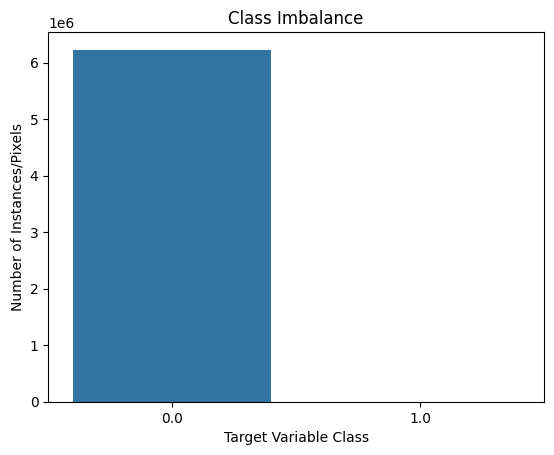

In [ ]:
sns.countplot(x='landslide_occ',data=dataset)
plt.title('Class Imbalance')
plt.xlabel('Target Variable Class')
plt.ylabel('Number of Instances/Pixels')
plt.show()

In [ ]:
class_0 = 6227428
class_1 = 882
log_0 = np.log(class_0)
log_1 = np.log(class_1)
X={'Class 0':log_0,'Class 1':log_1}
df_imb = pd.DataFrame(list(X.items()), columns=['Target Classes', 'Number of Instances/Pixels'])

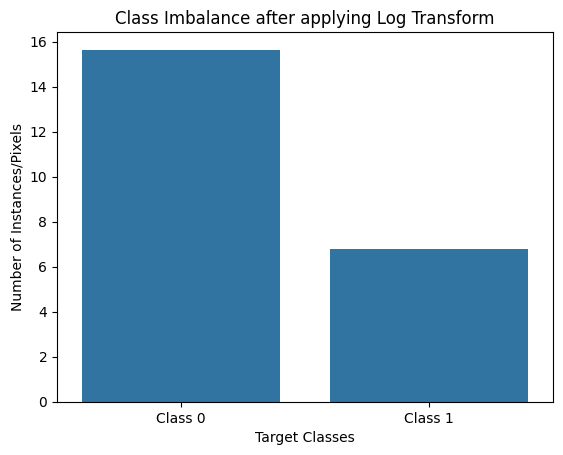

In [ ]:
sns.barplot(x='Target Classes', y='Number of Instances/Pixels', data=df_imb)
plt.title('Class Imbalance after applying Log Transform')
plt.show()

MultiCollinearity

In [ ]:
mc_df = dataset[['geology','geomorphology','lithology','soil_class','dist_to_water','dist_to_road','lulc',
             'rainfall','tan_cur','prof_curv','aspect','elevation','slope']]

In [ ]:
vif_data = pd.DataFrame()

In [ ]:
vif_data["feature"] = mc_df.columns

In [ ]:
vif_data["VIF"] = [variance_inflation_factor(mc_df.values, i) for i in range(len(mc_df.columns))]

In [ ]:
vif_data = vif_data.sort_values(by='VIF', ascending=False)

In [ ]:
vif_data["Tolerance"] = 1 / vif_data["VIF"]

In [ ]:
print(vif_data)

          feature        VIF  Tolerance
0         geology  53.086857   0.018837
7        rainfall  42.467258   0.023548
3      soil_class  16.987601   0.058866
11      elevation  14.528880   0.068828
2       lithology  12.631528   0.079167
6            lulc  11.109632   0.090012
12          slope   7.762729   0.128821
10         aspect   4.144968   0.241256
5    dist_to_road   2.908356   0.343837
4   dist_to_water   2.306932   0.433476
1   geomorphology   2.298650   0.435038
9       prof_curv   1.197908   0.834789
8         tan_cur   1.194800   0.836960


Robust Scaling

In [ ]:
rs = RobustScaler()

In [ ]:
X = dataset.drop(['landslide_occ','fid','longitude','latitude'], axis=1) #Remove unwanted columns and keep only the predictor features

In [ ]:
y = dataset['landslide_occ']

In [ ]:
X_scaled = rs.fit_transform(X)

In [ ]:
#Check for Multicollinearity again using Scaled values
scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
vif_data["VIF_after_scaling"] = [variance_inflation_factor(scaled_df.values, i) for i in range(len(scaled_df.columns))]

In [ ]:
vif_data["Tolerance_after_scaling"] = 1 / vif_data["VIF_after_scaling"]

In [ ]:
vif_data = vif_data.sort_values(by='VIF', ascending=False)

In [ ]:
vif_data

,feature,VIF,Tolerance,VIF_after_scaling,Tolerance_after_scaling
0,geology,53.086857,0.018837,3.736205,0.267651
7,rainfall,42.467258,0.023548,1.412201,0.708115
3,soil_class,16.987601,0.058866,3.243997,0.308262
11,elevation,14.528880,0.068828,2.319784,0.431075
2,lithology,12.631528,0.079167,1.362924,0.733717
6,lulc,11.109632,0.090012,2.007782,0.498062
12,slope,7.762729,0.128821,1.308720,0.764105
10,aspect,4.144968,0.241256,1.311993,0.762199
5,dist_to_road,2.908356,0.343837,1.194547,0.837137
4,dist_to_water,2.306932,0.433476,1.198226,0.834567


Modelling

Evaluate Model: Loss and Accuracy Func

In [ ]:
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    return loss, accuracy

Confusion Matrix Function

In [ ]:
def confusion_matrix_(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rounded_predictions = np.round(y_pred).astype(int)
    return y_pred, rounded_predictions

Training Testing Split

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)
print()
print(y.value_counts())
print()
print(y_train.value_counts())
print()
print(y_test.value_counts())

(4982648, 13)
(1245662, 13)
(4982648,)
(1245662,)

landslide_occ
0.0    6227428
1.0        882
Name: count, dtype: int64

landslide_occ
0.0    4981942
1.0        706
Name: count, dtype: int64

landslide_occ
0.0    1245486
1.0        176
Name: count, dtype: int64


In [ ]:
#class weights
a,b=y_train.value_counts()
class_0_weight=[(a+b)/(2*a)]
class_1_weight=[(a+b)/(2*b)]

In [ ]:
print(class_0_weight[0])
print(class_1_weight[0])

0.5000708559031799
3528.787535410765


ANN

In [ ]:
ANN_model = Sequential([
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(8,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1,activation='sigmoid')
])

In [ ]:
ANN_model.compile(optimizer=Adam(learning_rate=0.01), metrics=['accuracy'], loss='binary_crossentropy')

In [ ]:
history_1 = History()

In [ ]:
ANN_model.fit(X_train_scaled, y_train, epochs=5, batch_size=8196, validation_split = 0.2,
              verbose=1,callbacks=[history_1],class_weight={0:class_0_weight[0],1:class_1_weight[0]})

Epoch 1/5
487/487 [==============================] - 22s 38ms/step - loss: 0.5198 - accuracy: 0.7115 - val_loss: 0.4215 - val_accuracy: 0.7765
Epoch 2/5
487/487 [==============================] - 20s 40ms/step - loss: 0.4466 - accuracy: 0.7350 - val_loss: 0.4338 - val_accuracy: 0.7414
Epoch 3/5
487/487 [==============================] - 18s 37ms/step - loss: 0.4081 - accuracy: 0.7711 - val_loss: 0.3530 - val_accuracy: 0.8230
Epoch 4/5
487/487 [==============================] - 18s 37ms/step - loss: 0.3882 - accuracy: 0.7843 - val_loss: 0.4344 - val_accuracy: 0.7632
Epoch 5/5
487/487 [==============================] - 19s 40ms/step - loss: 0.3832 - accuracy: 0.7997 - val_loss: 0.3363 - val_accuracy: 0.8147


In [ ]:
loss_ANN, accuracy_ANN = evaluate_model(ANN_model, X_test_scaled, y_test)
print("Testing Loss for ANN:", loss_ANN)
print("Testing Accuracy for ANN:", accuracy_ANN)

38927/38927 [==============================] - 72s 2ms/step - loss: 0.3358 - accuracy: 0.8147
Testing Loss for ANN: 0.33576831221580505
Testing Accuracy for ANN: 0.8147033452987671


In [ ]:
y_pred_ANN, roun_pred_ANN = confusion_matrix_(ANN_model, X_test_scaled, y_test)
print(y_pred_ANN.shape)
print(roun_pred_ANN.shape)

38927/38927 [==============================] - 70s 2ms/step
(1245662, 1)
(1245662, 1)


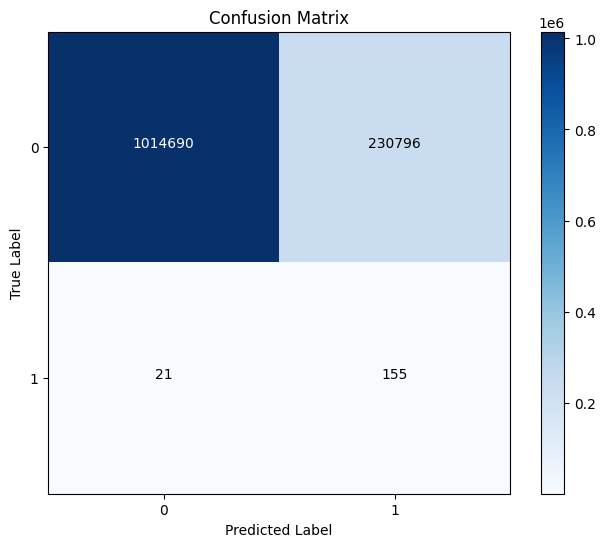

In [ ]:
cm = confusion_matrix(y_test, roun_pred_ANN)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
plt.show()

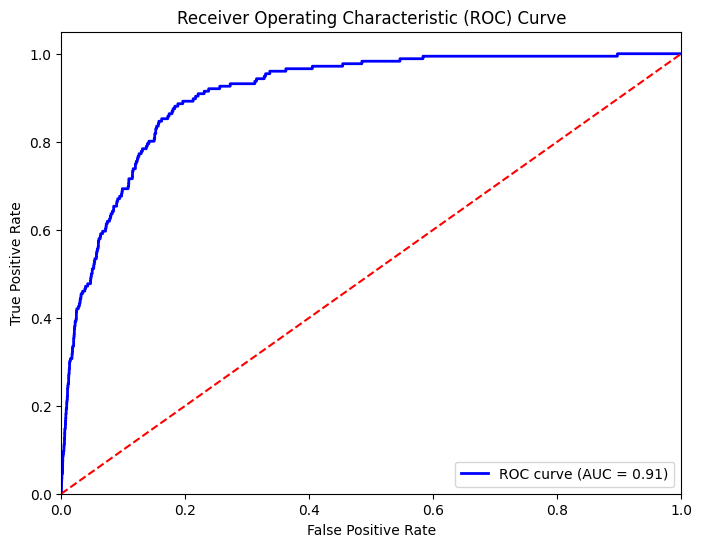

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ANN)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_ANN))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
ANN_model.save('ANN_MODEL_SAVED_FINAL.h5')
import pickle
with open('ANN_MODEL_Training_History_FINAL.pkl', 'wb') as file:
    pickle.dump(history_1.history, file)
np.savetxt('AUC_ROC_SCORE_DF_ANN_FINAL.csv', y_pred_ANN, delimiter=",")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


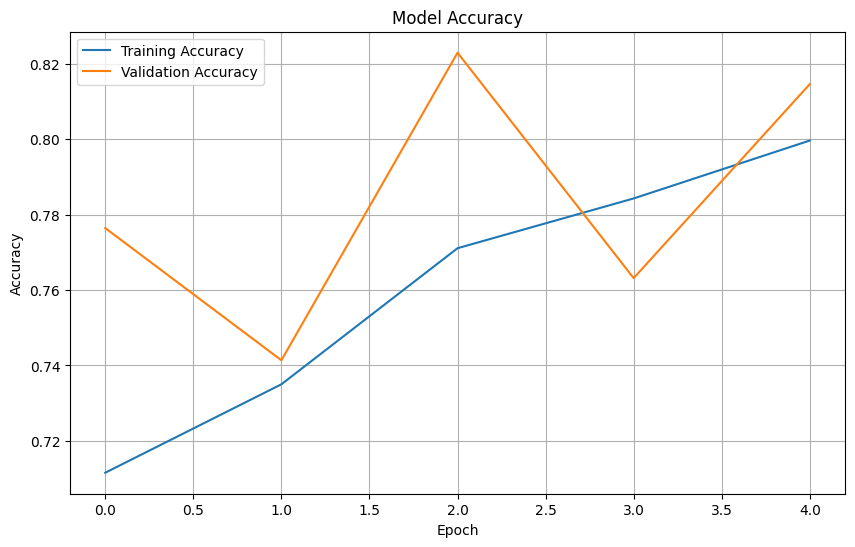

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

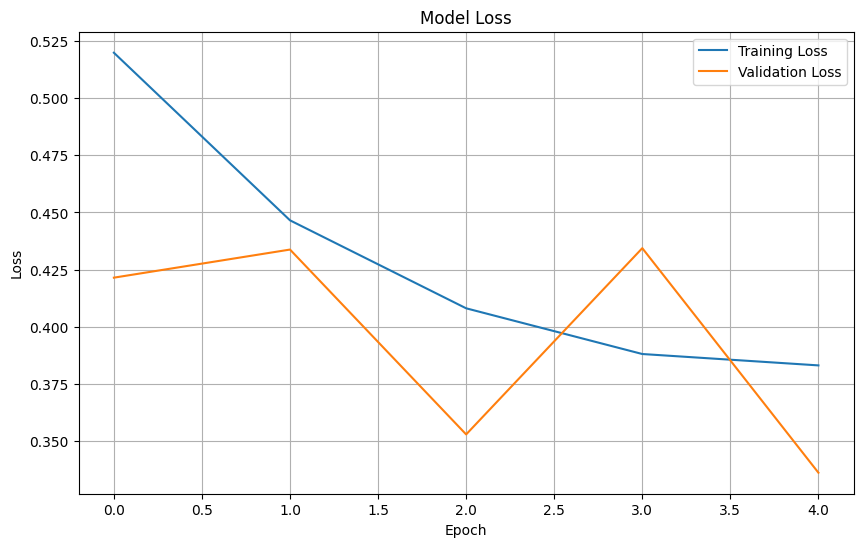

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
truncated_history = {key: value[:5] for key, value in history_1.history.items()}
history_1 = truncated_history

In [ ]:
dataset_shuffled = shuffle(dataset, random_state=0)
dataset_proba=dataset_shuffled.drop(['fid','longitude','latitude','landslide_occ'],axis=1,inplace=False)
dataset_proba_scaled = rs.fit_transform(dataset_proba)

In [ ]:
probabilities_ANN = ANN_model.predict(dataset_proba_scaled)

194635/194635 [==============================] - 413s 2ms/step


In [ ]:
probabilities_ANN

array([[0.0057813 ],
       [0.3893457 ],
       [0.69007903],
       ...,
       [0.0212659 ],
       [0.00295231],
       [0.01728266]], dtype=float32)

In [ ]:
probabilities_ANN.shape

(6228310, 1)

In [ ]:
probabilities_ANN = probabilities_ANN.reshape(-1)

In [ ]:
probabilities_ANN.shape

(6228310,)

In [ ]:
len(probabilities_ANN)
result_df_ANN = pd.DataFrame({
    'fid': dataset_shuffled['fid'],
    'longitude': dataset_shuffled['longitude'],
    'latitude': dataset_shuffled['latitude'],
    'predicted_probabilities': probabilities_ANN
})
print(result_df_ANN.shape)

(6228310, 4)


In [ ]:
result_df_ANN.to_csv('output_ANN.csv', index=False)

CNN - 1D

In [ ]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0],X_train_scaled.shape[1],1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0],X_test_scaled.shape[1],1))

print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(4982648, 13, 1)
(1245662, 13, 1)


In [ ]:
CNN_model = Sequential ([
    Conv1D(filters=10, kernel_size=3, activation='relu', input_shape=(13,1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.20),
    Conv1D(filters=6, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.20),
    Flatten(),
    Dense(4, activation='relu'),
    BatchNormalization(),
    Dropout(0.20),
    Dense(2, activation='relu'),
    BatchNormalization(),
    Dropout(0.20),
    Dense(1, activation='sigmoid')
])

In [ ]:
CNN_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_2 = History()

In [ ]:
CNN_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=8192, validation_split = 0.2,
              verbose=1,callbacks=[history_2],class_weight={0:class_0_weight[0],1:class_1_weight[0]})

Epoch 1/10
487/487 [==============================] - 49s 93ms/step - loss: 0.5170 - accuracy: 0.7998 - val_loss: 0.4087 - val_accuracy: 0.7661
Epoch 2/10
487/487 [==============================] - 44s 89ms/step - loss: 0.5025 - accuracy: 0.7831 - val_loss: 0.4388 - val_accuracy: 0.7305
Epoch 3/10
487/487 [==============================] - 42s 87ms/step - loss: 0.4983 - accuracy: 0.7766 - val_loss: 0.4251 - val_accuracy: 0.7372
Epoch 4/10
487/487 [==============================] - 45s 91ms/step - loss: 0.5048 - accuracy: 0.7713 - val_loss: 0.4279 - val_accuracy: 0.7337
Epoch 5/10
487/487 [==============================] - 44s 90ms/step - loss: 0.4787 - accuracy: 0.7752 - val_loss: 0.4098 - val_accuracy: 0.7536
Epoch 6/10
487/487 [==============================] - 46s 94ms/step - loss: 0.4874 - accuracy: 0.7868 - val_loss: 0.4161 - val_accuracy: 0.7420
Epoch 7/10
487/487 [==============================] - 43s 87ms/step - loss: 0.4967 - accuracy: 0.7879 - val_loss: 0.4342 - val_accuracy:

In [ ]:
loss_CNN, accuracy_CNN = evaluate_model(CNN_model, X_test_reshaped, y_test)
print("Testing Loss for ANN:", loss_CNN)
print("Testing Accuracy for ANN:", accuracy_CNN)

38927/38927 [==============================] - 111s 3ms/step - loss: 0.4151 - accuracy: 0.7434
Testing Loss for ANN: 0.4150657057762146
Testing Accuracy for ANN: 0.7433573603630066


In [ ]:
y_pred_CNN, roun_pred_CNN = confusion_matrix_(CNN_model, X_test_reshaped, y_test)
print(y_pred_CNN.shape)
print(roun_pred_CNN.shape)

38927/38927 [==============================] - 100s 3ms/step
(1245662, 1)
(1245662, 1)


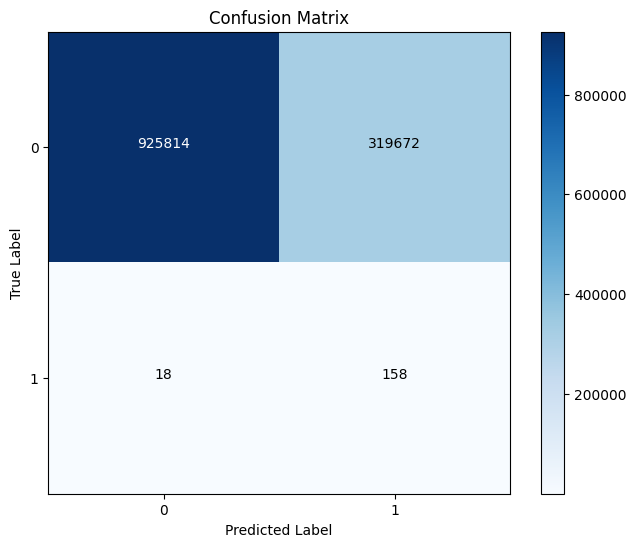

In [ ]:
cm = confusion_matrix(y_test, roun_pred_CNN)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
plt.show()

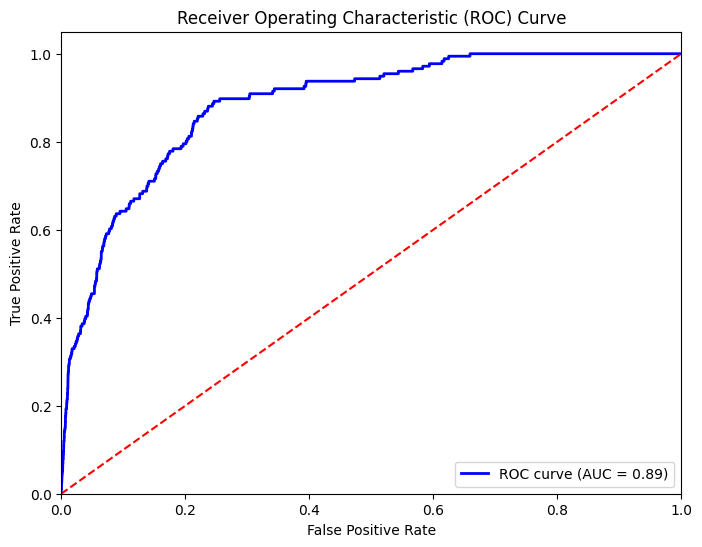

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_CNN)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_CNN))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
CNN_model.save('CNN_MODEL_SAVED_FINAL.h5')
import pickle
with open('CNN_MODEL_Training_History_FINAL.pkl', 'wb') as file:
    pickle.dump(history_2.history, file)
np.savetxt('AUC_ROC_SCORE_DF_CNN_FINAL.csv', y_pred_CNN, delimiter=",")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


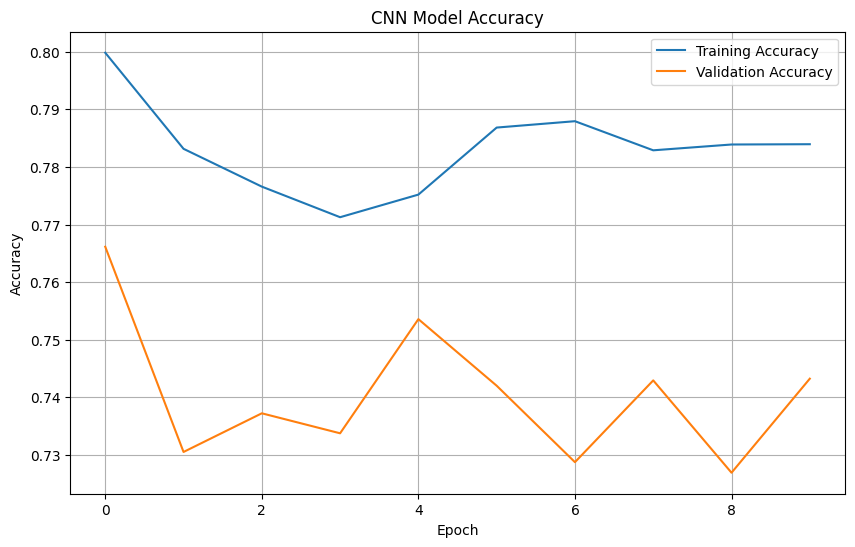

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

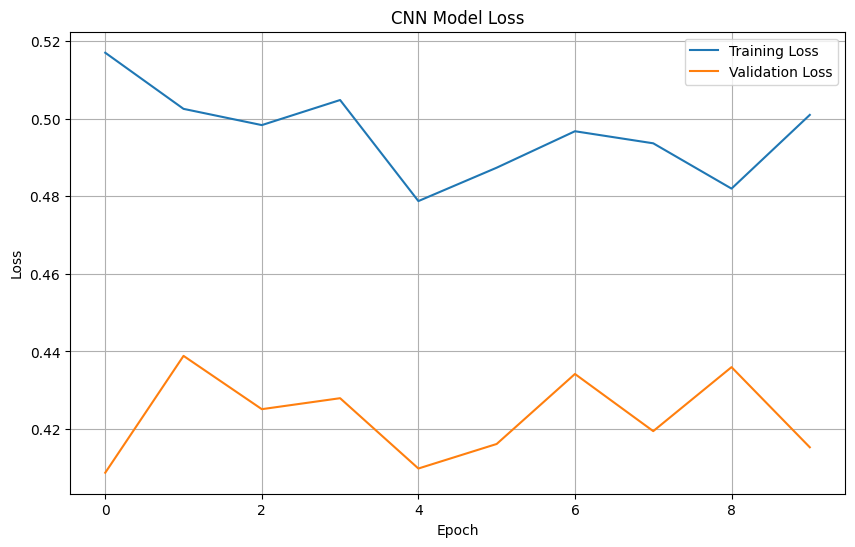

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model = load_model('/content/CNN_MODEL_SAVED_FINAL.h5')

In [ ]:
loss_CNN_new, accuracy_CNN_new = evaluate_model(model, X_test_reshaped, y_test)
print("Testing Loss for CNN:", loss_CNN_new)
print("Testing Accuracy for CNN:", accuracy_CNN_new)

38927/38927 [==============================] - 98s 2ms/step - loss: 0.4151 - accuracy: 0.7434
Testing Loss for CNN: 0.4150657057762146
Testing Accuracy for CNN: 0.7433573603630066


In [ ]:
probabilities_CNN = model.predict(dataset_proba_scaled)

194635/194635 [==============================] - 431s 2ms/step


In [ ]:
probabilities_CNN.shape

(6228310, 1)

In [ ]:
probabilities_CNN = probabilities_CNN.reshape(-1)

In [ ]:
probabilities_CNN.shape

(6228310,)

In [ ]:
len(probabilities_CNN)
result_df_CNN = pd.DataFrame({
    'fid': dataset_shuffled['fid'],
    'longitude': dataset_shuffled['longitude'],
    'latitude': dataset_shuffled['latitude'],
    'predicted_probabilities': probabilities_CNN
})
print(result_df_CNN.shape)

(6228310, 4)


In [ ]:
result_df_CNN.to_csv('output_CNN.csv', index=False)

RNN

In [ ]:
RNN_model = Sequential ([
    SimpleRNN(units=64, activation='relu',return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),
    Dense(units=15, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    GlobalAveragePooling1D(),
    Dense(units=1, activation='sigmoid')
])

In [ ]:
RNN_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_3 = History()

In [ ]:
RNN_model.fit(X_train_reshaped,y_train,epochs=5,batch_size=512, validation_split = 0.2,
              verbose=1,callbacks=[history_3],class_weight={0:class_0_weight[0],1:class_1_weight[0]})

Epoch 1/5
7786/7786 [==============================] - 105s 13ms/step - loss: 0.6122 - accuracy: 0.6468 - val_loss: 1.6344 - val_accuracy: 0.1264
Epoch 2/5
7786/7786 [==============================] - 103s 13ms/step - loss: 0.5671 - accuracy: 0.6828 - val_loss: 0.3942 - val_accuracy: 0.8425
Epoch 3/5
7786/7786 [==============================] - 103s 13ms/step - loss: 0.5264 - accuracy: 0.7194 - val_loss: 0.2560 - val_accuracy: 0.9901
Epoch 4/5
7786/7786 [==============================] - 106s 14ms/step - loss: 0.4560 - accuracy: 0.7437 - val_loss: 0.3061 - val_accuracy: 0.8389
Epoch 5/5
7786/7786 [==============================] - 104s 13ms/step - loss: 0.4234 - accuracy: 0.7873 - val_loss: 0.6125 - val_accuracy: 0.7329


In [ ]:
loss_RNN, accuracy_RNN = evaluate_model(RNN_model, X_test_reshaped, y_test)
print("Testing Loss for ANN:", loss_RNN)
print("Testing Accuracy for ANN:", accuracy_RNN)

38927/38927 [==============================] - 95s 2ms/step - loss: 0.6131 - accuracy: 0.7323
Testing Loss for ANN: 0.61314457654953
Testing Accuracy for ANN: 0.7322676777839661


In [ ]:
y_pred_RNN, roun_pred_RNN = confusion_matrix_(RNN_model, X_test_reshaped, y_test)
print(y_pred_RNN.shape)
print(roun_pred_RNN.shape)

38927/38927 [==============================] - 78s 2ms/step
(1245662, 1)
(1245662, 1)


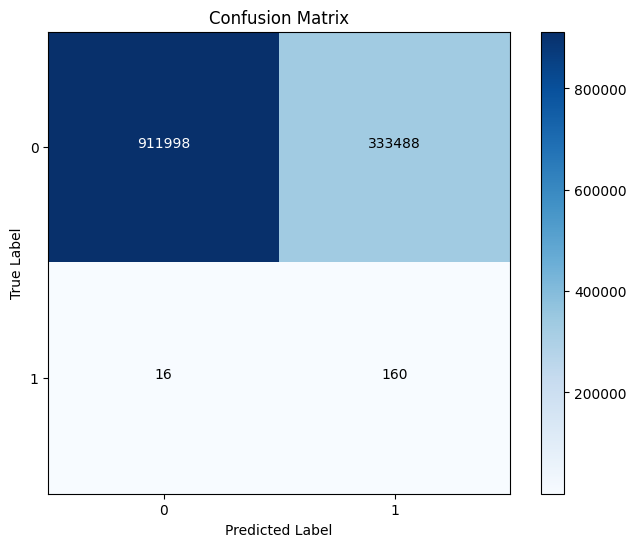

In [ ]:
cm = confusion_matrix(y_test, roun_pred_RNN)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
plt.show()

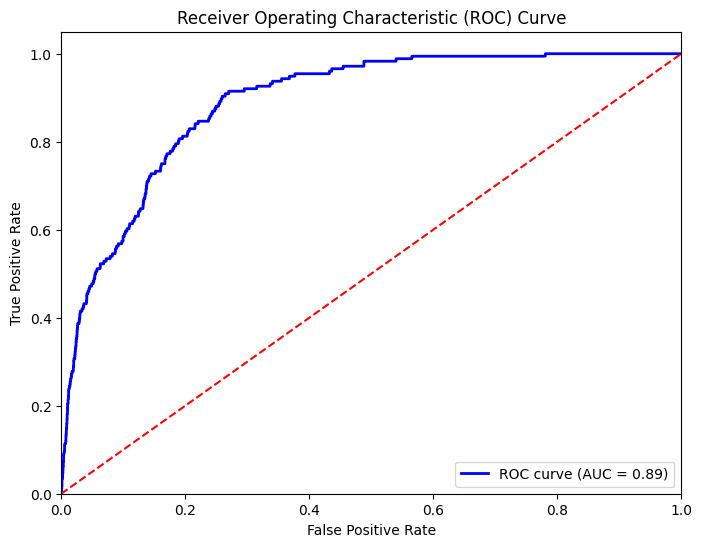

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_RNN)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_RNN))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
RNN_model.save('RNN_MODEL_SAVED_FINAL.h5')
import pickle
with open('RNN_MODEL_Training_History_FINAL.pkl', 'wb') as file:
    pickle.dump(history_3.history, file)
np.savetxt('AUC_ROC_SCORE_DF_RNN_FINAL.csv', y_pred_RNN, delimiter=",")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


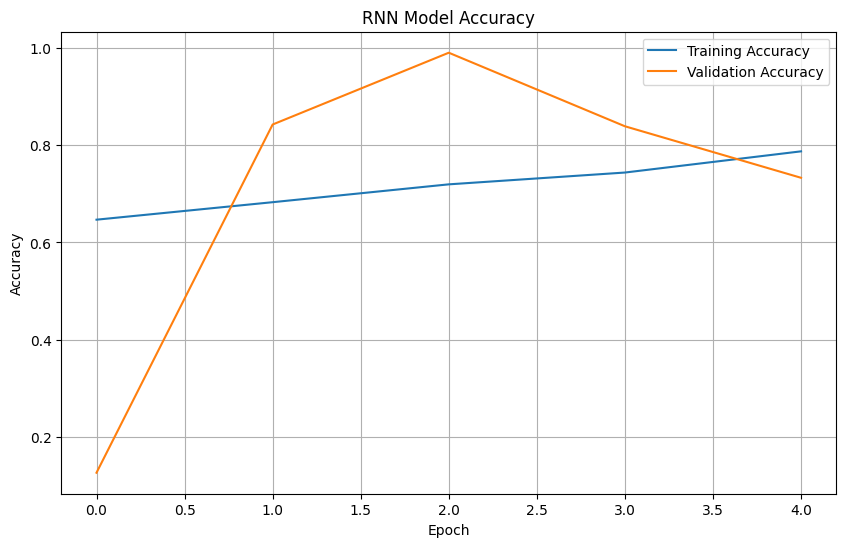

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

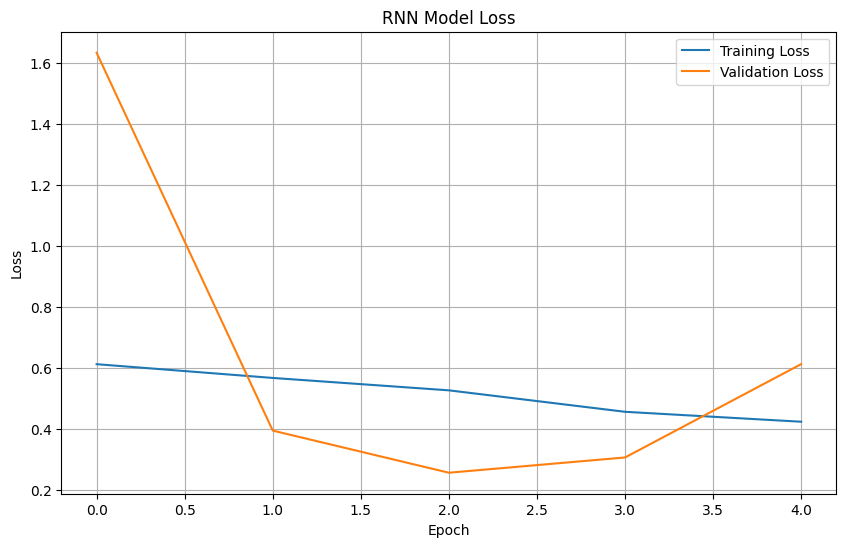

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
RNN_FEED = dataset_proba_scaled.reshape((dataset_proba_scaled.shape[0],dataset_proba_scaled.shape[1],1))

In [ ]:
RNN_FEED.shape

(6228310, 13, 1)

In [ ]:
probabilities_RNN = RNN_model.predict(RNN_FEED)

194635/194635 [==============================] - 378s 2ms/step


In [ ]:
probabilities_RNN.shape

(6228310, 1)

In [ ]:
probabilities_RNN = probabilities_RNN.reshape(-1)

In [ ]:
probabilities_RNN.shape

(6228310,)

In [ ]:
len(probabilities_RNN)
result_df_RNN = pd.DataFrame({
    'fid': dataset_shuffled['fid'],
    'longitude': dataset_shuffled['longitude'],
    'latitude': dataset_shuffled['latitude'],
    'predicted_probabilities': probabilities_RNN
})
print(result_df_RNN.shape)

(6228310, 4)


In [ ]:
result_df_RNN.to_csv('output_RNN.csv', index=False)

LSTM

In [ ]:
LSTM_model = Sequential([
    LSTM(30,return_sequences=False),
    BatchNormalization(),
    Dense(15,activation='relu'),
    BatchNormalization(),
    Dense(1,activation='sigmoid'),
])

In [ ]:
LSTM_model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_4=History()

In [ ]:
checkpoint_callback = ModelCheckpoint('weights_epoch_{epoch:02d}.h5', save_weights_only=True)

In [ ]:
LSTM_model.fit(X_train_reshaped, y_train, epochs=5, batch_size=128, validation_split = 0.2,
              verbose=1, callbacks=[history_4,checkpoint_callback], class_weight={0:class_0_weight[0],1:class_1_weight[0]})

Epoch 1/5
31142/31142 [==============================] - 345s 11ms/step - loss: 0.6829 - accuracy: 0.5881 - val_loss: 0.6724 - val_accuracy: 0.4674
Epoch 2/5
31142/31142 [==============================] - 353s 11ms/step - loss: 0.5802 - accuracy: 0.6384 - val_loss: 0.3843 - val_accuracy: 0.8145
Epoch 3/5
31142/31142 [==============================] - 341s 11ms/step - loss: 0.4451 - accuracy: 0.7740 - val_loss: 0.2871 - val_accuracy: 0.9021
Epoch 4/5
31142/31142 [==============================] - 355s 11ms/step - loss: 0.4006 - accuracy: 0.8248 - val_loss: 0.3202 - val_accuracy: 0.8453
Epoch 5/5
31142/31142 [==============================] - 353s 11ms/step - loss: 0.3714 - accuracy: 0.8383 - val_loss: 0.4220 - val_accuracy: 0.7958


In [ ]:
LSTM_model.load_weights('weights_epoch_05.h5')

In [ ]:
loss_LSTM, accuracy_LSTM = evaluate_model(LSTM_model, X_test_reshaped, y_test)
print("Testing Loss for ANN:", loss_LSTM)
print("Testing Accuracy for ANN:", accuracy_LSTM)

38927/38927 [==============================] - 137s 4ms/step - loss: 0.4219 - accuracy: 0.7958
Testing Loss for ANN: 0.4218849241733551
Testing Accuracy for ANN: 0.7958009243011475


In [ ]:
y_pred_LSTM, roun_pred_LSTM = confusion_matrix_(LSTM_model, X_test_reshaped, y_test)
print(y_pred_LSTM.shape)
print(roun_pred_LSTM.shape)

38927/38927 [==============================] - 124s 3ms/step
(1245662, 1)
(1245662, 1)


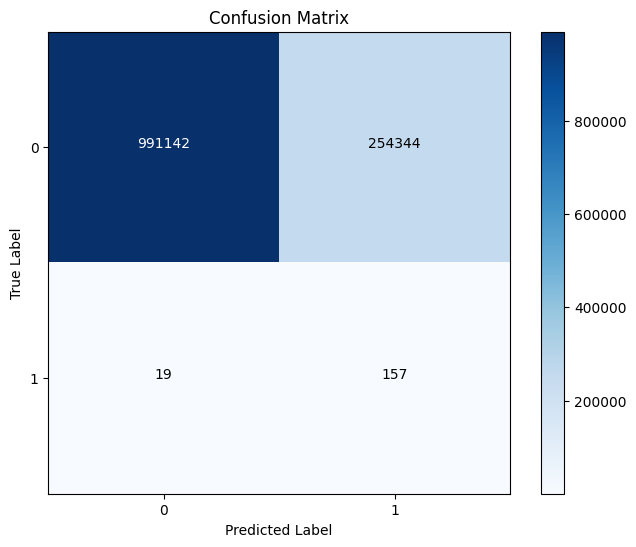

In [ ]:
cm = confusion_matrix(y_test, roun_pred_LSTM)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
plt.show()

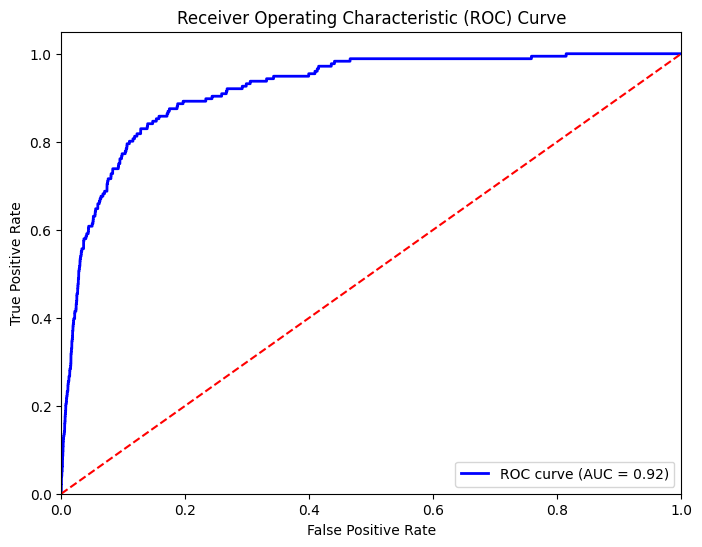

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_LSTM)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_LSTM))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
LSTM_model.save('LSTM_MODEL_SAVED_FINAL.h5')
import pickle
with open('LSTM_MODEL_Training_History_FINAL.pkl', 'wb') as file:
    pickle.dump(history_4.history, file)
np.savetxt('AUC_ROC_SCORE_DF_LSTM_FINAL.csv', y_pred_LSTM, delimiter=",")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


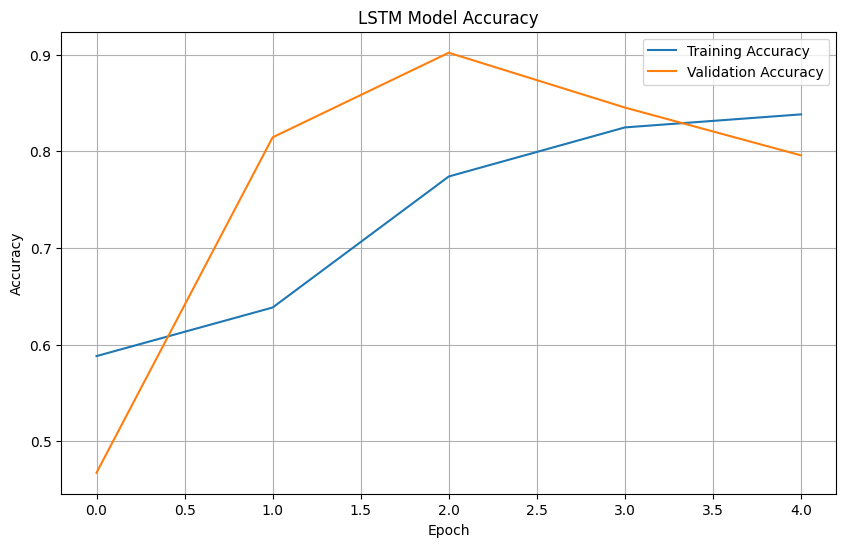

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_4.history['accuracy'], label='Training Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

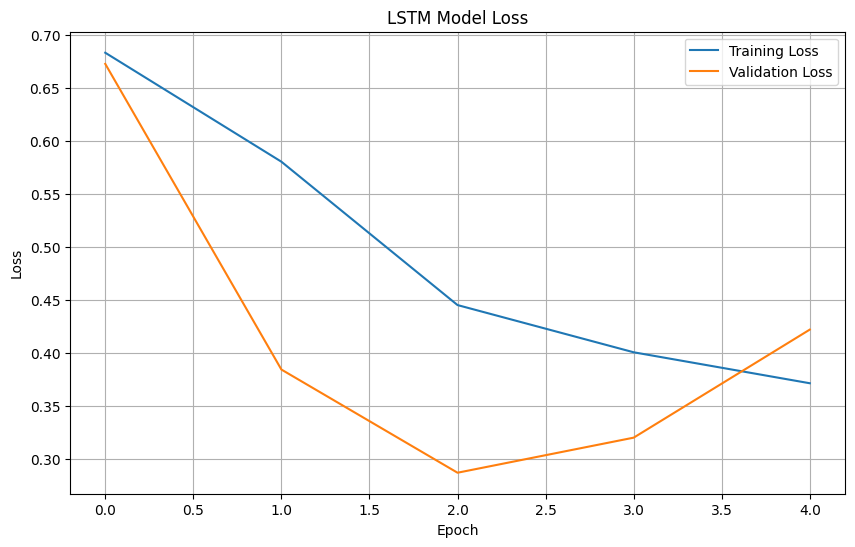

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_4.history['loss'], label='Training Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
LSTM_FEED = dataset_proba_scaled.reshape((dataset_proba_scaled.shape[0],dataset_proba_scaled.shape[1],1))

In [ ]:
LSTM_FEED.shape

(6228310, 13, 1)

In [ ]:
probabilities_LSTM = LSTM_model.predict(LSTM_FEED)

194635/194635 [==============================] - 1136s 6ms/step


In [ ]:
probabilities_LSTM.shape

(6228310, 1)

In [ ]:
probabilities_LSTM = probabilities_LSTM.reshape(-1)

In [ ]:
probabilities_LSTM.shape

(6228310,)

In [ ]:
len(probabilities_LSTM)
result_df_LSTM = pd.DataFrame({
    'fid': dataset_shuffled['fid'],
    'longitude': dataset_shuffled['longitude'],
    'latitude': dataset_shuffled['latitude'],
    'predicted_probabilities': probabilities_LSTM
})
print(result_df_LSTM.shape)

(6228310, 4)


In [ ]:
result_df_LSTM.to_csv('output_LSTM.csv', index=False)

In [ ]:
result_df_LSTM.isna().sum()

fid                        0
longitude                  0
latitude                   0
predicted_probabilities    0
dtype: int64